# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

In [1]:
import torch
from torch import *
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [40]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data', train = False, transform = transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader
train_loader, test_loader = load_dataloaders()
print("The number of batches in a test_loader is: ", len(test_loader))

print("The number of batches in a train_loader is: ", len(train_loader))


Files already downloaded and verified
The number of batches in a test_loader is:  157
The number of batches in a train_loader is:  782


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [41]:
def imshow(images, labels, padding_size=15, labels_split_size=12):
    # убрать нормализацию
    npimg = images.numpy()
    images = images
    
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


               cat            ship            ship            plane


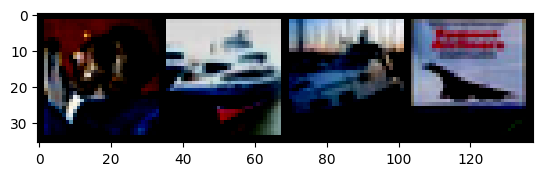

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images

dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:4]),(labels[0:4]))


## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [44]:
import torch.nn as nn
class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential(
            nn.Conv2d(3,32,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(32)

        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [45]:
net = ResidualNet()

assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [ ]:
!pip install cuda-python

In [46]:
print('Pytorch CUDA Version is', torch.version.cuda)

Pytorch CUDA Version is None


In [47]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [8]:
torch.cuda.is_available()

False

In [48]:
class Trainer:

    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)

        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):

        self.train_loss_log = []
        self.train_acc_log = []
        self.test_loss_log = []
        self.test_acc_log = []

        for epoch in range(1,n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")

    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

In [49]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) ), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) ), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) ), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) ), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [50]:
model = ResidualNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn)
#trainer._train_epoch(train_loader)
#trainer.test(test_loader)
trainer.train(train_loader, test_loader, 5)

Сеть загружена на cpu


C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\3639198586.py:42: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for epoch in range(1,n_epochs):


Epoch 1.0
 train loss: 91.88472033888483, train acc: 0.4883112212276215
 test loss: 77.62951754916246, test acc: 0.5589171974522293

Epoch 2.0
 train loss: 71.96878852990582, train acc: 0.6022418478260869
 test loss: 68.00283266176844, test acc: 0.6241042993630573

Epoch 3.0
 train loss: 64.86101714424466, train acc: 0.6451007033248082
 test loss: 65.45411677876855, test acc: 0.637937898089172

Epoch 4.0
 train loss: 61.41997285511183, train acc: 0.6651214833759591
 test loss: 59.956954700931625, test acc: 0.6732683121019108

Epoch 5.0
 train loss: 58.961403684542915, train acc: 0.6791879795396419
 test loss: 59.05677464357607, test acc: 0.6766520700636943



C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\1408962514.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.train_loss_log) ), trainer.train_loss_log, label='train')
C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\1408962514.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.test_loss_log) ), trainer.test_loss_log, label='test')
C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\1408962514.py:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values 

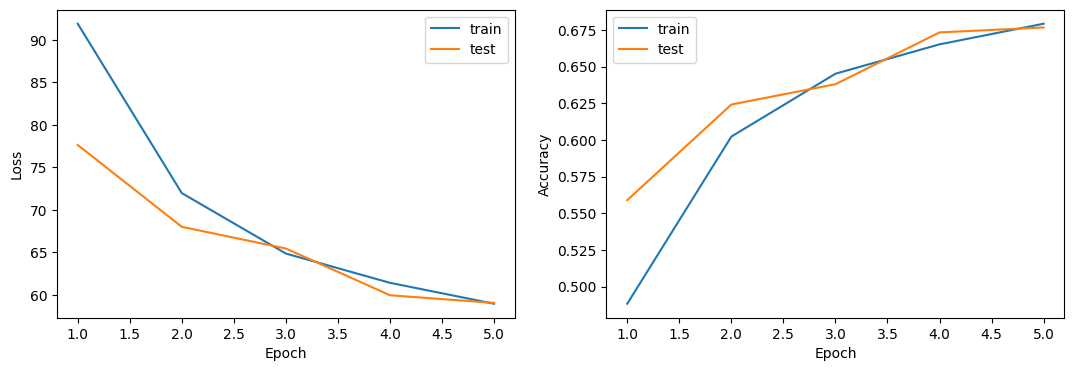

In [51]:
plot_train_log(trainer)

## Task 5


Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет.
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [52]:
transform_v2 = transforms.Compose(
        [
            #transforms.CenterCrop(10),
            #transforms.Resize(205),
#             transforms.GaussianBlur(1),
#             transforms.RandomGrayscale(p=0.05),
            transforms.RandomRotation(degrees = 3),
            transforms.RandomInvert(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)#каждое изображение с какой-то долей вероятности (p) поворачивается, сжимается, обрезается, меняет цвета и яркость

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


               cat            ship            ship            plane


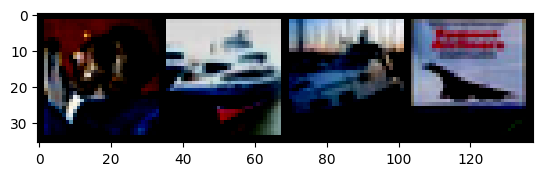

In [53]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[0:4]),(labels[0:4]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


               cat            ship            ship            plane


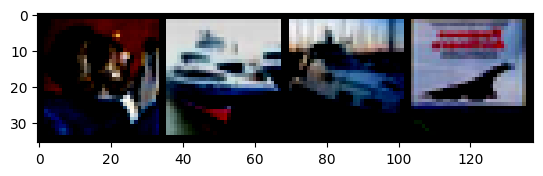

In [59]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
])

# Применение аугментаций к изображениям
augmented_images = transform(images)

# Вывод аугментированных изображений на экран
imshow(torchvision.utils.make_grid(augmented_images[0:4]), labels[0:4])

Files already downloaded and verified
Сеть загружена на cpu


C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\3639198586.py:42: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for epoch in range(1,n_epochs):


Epoch 1.0
 train loss: 71.52525383737081, train acc: 0.6083359974424553
 test loss: 62.02080768232892, test acc: 0.6642117834394905

Epoch 2.0
 train loss: 68.09365913996001, train acc: 0.6286165281329923
 test loss: 60.35236463121548, test acc: 0.6658041401273885

Epoch 3.0
 train loss: 66.64846347238097, train acc: 0.6368286445012787
 test loss: 61.10823252854074, test acc: 0.6664012738853503

Epoch 4.0
 train loss: 65.35784403320469, train acc: 0.6414641943734015
 test loss: 58.692702493849836, test acc: 0.6786425159235668

Epoch 5.0
 train loss: 64.0988702249649, train acc: 0.651474584398977
 test loss: 57.37210729319578, test acc: 0.6817277070063694



C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\1408962514.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.train_loss_log) ), trainer.train_loss_log, label='train')
C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\1408962514.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  axs[0].plot(range(1, len(trainer.test_loss_log) ), trainer.test_loss_log, label='test')
C:\Users\sv_k7\AppData\Local\Temp\ipykernel_25040\1408962514.py:8: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values 

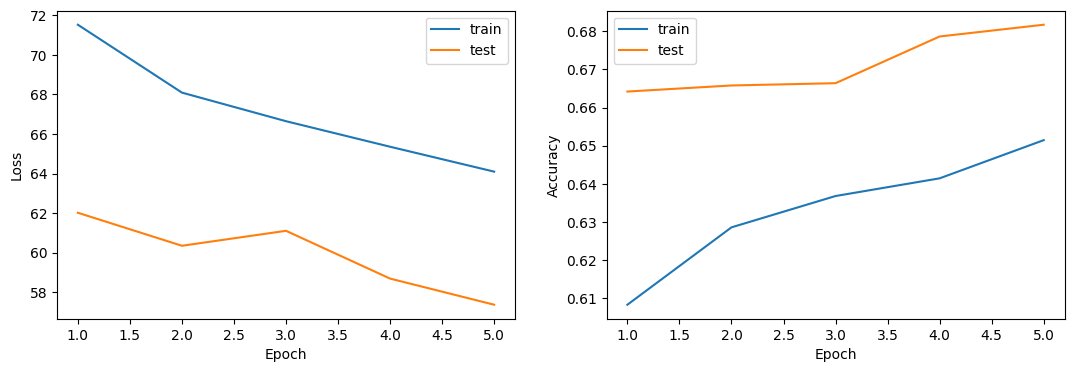

In [62]:
import random

def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE, augment_data=False):
    if augment_data:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transform
        ])
    else:
        train_transform = transform

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_loader, test_loader

# Создайте загрузчики данных с аугментацией
train_loader_augmented, test_loader_augmented = load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE, augment_data=True)

# Создайте новый объект Trainer с моделью и загрузчиками данных с аугментацией
trainer_augmented = Trainer(model, optimizer, loss_fn)
trainer_augmented.train(train_loader_augmented, test_loader_augmented, 5)

# Визуализируйте процесс обучения с аугментацией данных
plot_train_log(trainer_augmented)
